# MA Thesis: Controlling the benjolin through the latent space

In [1]:
from google.colab import drive
drive.mount('MyDrive')

Mounted at MyDrive


In [2]:
import numpy as np
import torch;# torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions as dists
import librosa
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt

## 1. Dataset

In [18]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset



class MFCCDataset(Dataset):
  def __init__(self, data_dir):  # Adjust max_length as needed
    self.data_dir = data_dir
    self.mfcc_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith("_1.npy")]

  def __len__(self):
    return len(self.mfcc_files)

  def __getitem__(self, idx):
    mfcc_path = self.mfcc_files[idx]
    mfcc_data = np.load(mfcc_path)
    mfcc_data = mfcc_data.T
    # print(mfcc_data.shape)

    tensor = torch.from_numpy(mfcc_data).float()
    tensor = torch.clip(tensor, min=-25, max=25)
    tensor += 25
    tensor /= 50

    return tensor


data_dir = "/content/MyDrive/MyDrive/KTH/aMASTER THESIS/Data/MFCC_12_split"
dataset = MFCCDataset(data_dir)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=None, shuffle=True)
device = "cuda"
print(dataset[0].shape)


torch.Size([10, 12])


### 1.b dataset stats

In [ ]:
def calculate_dataset_stats(dataset):
  # Initialize variables
  data_sum = 0
  data_squared_sum = 0
  min_val = torch.tensor(torch.inf)
  max_val = torch.tensor(-torch.inf)
  # entire_dataset = torch.zeros((len(dataset), 1270))

  # Iterate through the dataset
  index = 0
  for datapoint in dataset:
    """# Assuming your datapoint is a tensor
    data = datapoint  # Access the first element (modify if datapoint structure differs)
    data = data.flatten()  # Flatten the tensor for calculations
    # print(data.shape)
    entire_dataset[index, :] = data"""
    print(index)
    index += 1
    # Update statistics
    data = datapoint
    data_sum += torch.sum(data)
    data_squared_sum += torch.sum(data**2)
    min_val = torch.min(min_val, torch.min(data))
    max_val = torch.max(max_val, torch.max(data))


  # Calculate mean and standard deviation
  if len(dataset) > 0:  # Avoid division by zero
    mean = data_sum / (len(dataset) * torch.prod(torch.tensor(datapoint[0].shape)))  # Adjust for datapoint structure
    std = torch.sqrt((data_squared_sum / (len(dataset) * torch.prod(torch.tensor(datapoint[0].shape))) - mean**2))
  else:
    mean = 0
    std = 0

  # Print statistics
  print("Mean:", mean.item())
  print("Standard Deviation:", std.item())
  print("Minimum:", min_val.item())
  print("Maximum:", max_val.item())
  """
  plt.hist(entire_dataset.flatten(), bins=100)
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.title('Histogram of Dataset Values')
  plt.grid(True)
  plt.show()"""

# Example usage (assuming your dataset is loaded)
calculate_dataset_stats(dataset)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

## 2. MODEL DEFINITION

In [5]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim, sequence_length, num_layers=1):
    super(Encoder, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.latent_dim = latent_dim
    self.num_layers = num_layers


    self.LSTM_encoder = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
    self.linear_mu = nn.Linear(self.hidden_dim * 2, self.latent_dim)  # 2*hidden because the lstm hidden and cell states are concatenated
    self.linear_sigma = nn.Linear(self.hidden_dim * 2, self.latent_dim)  # same as above
    self.kl = 0

  def reparametrization(self, mu, sigma):
    return mu + sigma * dists.Normal(0, 1).sample(mu.shape).to(device)

  def forward(self, x):
    # Layer 1: LSTM
    x = x.to(device)
    output, (h_n, c_n) = self.LSTM_encoder(x)

    # concatenating the final hidden and cell states
    x_lstm = torch.cat((h_n, c_n), dim=1)

    # Layer 2 MU (Parallell with Layer 3)
    mu = self.linear_mu(x_lstm)
    # Layer 3 SIGMA (Parallell with Layer 2)
    log_var = self.linear_sigma(x_lstm)
    sigma = torch.exp(log_var)

    # Sampling a latent vector z
    z = self.reparametrization(mu, sigma)

    self.kl = torch.sum((sigma**2 + mu**2 - log_var - 1/2)).to(device)
    return z, mu, log_var

In [11]:
class Decoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim, LSTM_layers=1, teacher_forcing=False, tf_ratio = 0.3):
    super(Decoder, self).__init__()
    self.LSTM_layers = LSTM_layers
    self.hidden_dim = hidden_dim
    self.teacher_forcing = False
    self.tf_ratio = tf_ratio

    self.linear_h = nn.Linear(latent_dim, hidden_dim)
    self.linear_c = nn.Linear(latent_dim, hidden_dim)
    self.linear_mid = nn.Linear(hidden_dim, hidden_dim * 10)
    self.relu = nn.ReLU()

    self.LSTM_dec = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=LSTM_layers)
    self.linear_out = nn.Linear(hidden_dim, input_dim)

  def forward(self, z, target=None):
    # Dense layers to get hidden and cell states
    hidden = self.linear_h(z)
    cell = self.linear_c(z)


    y = self.linear_out(hidden)

    # empty output
    outputs = torch.zeros(sequence_length, input_dim)
    for t in range(sequence_length):
      # predict next value in sequence
      out, (hidden, cell) = self.LSTM_dec(y, (hidden, cell))  # Pass through LSTM
      y = self.linear_out(out)
      # store the output
      outputs[t, :] = y

      # teacher forcing with probability tf_ratio
      if target != None and self.teacher_forcing and random.random() < self.tf_ratio:
        y = target[t]

    return outputs


In [7]:
class VariationalAutoencoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim, sequence_length):
    super(VariationalAutoencoder, self).__init__()
    self.encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, sequence_length=sequence_length)
    self.decoder = Decoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, teacher_forcing=True, tf_ratio=0.5)

  def forward(self, x):
    z, _, _ = self.encoder.forward(x)
    x_hat = self.decoder.forward(z, x)
    return x_hat


In [8]:
def train(vae, data, epochs, learning_rate=1e-4, beta = 1e-5):
  opt = torch.optim.Adam(vae.parameters(), lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)
  for epoch in range(epochs):
    loss_epoch = 0
    for x in data:
      x = x.to(device)
      opt.zero_grad()

      z, _, _ = vae.encoder.forward(x)
      x_hat = vae.decoder.forward(z, x).to(device)

      kl = vae.encoder.kl.to(device)
      recon_loss = F.mse_loss(x_hat, x)
      standard_vae_loss = recon_loss + beta * kl
      loss_epoch += standard_vae_loss
      standard_vae_loss.backward()
      opt.step()
    scheduler.step()
    print(f"Epoch: {epoch + 1} out of {epochs}", "\nLoss this epoch: ", loss_epoch.item())
  return vae

## 3. Training the Model

In [ ]:
input_dim = 12
hidden_dim = 512
latent_dim = 16
LSTM_layers = 2

sequence_length = 10
lr = 1e-4

device = "cuda"
vae = VariationalAutoencoder().to(device)


# vae = train(vae, data_loader, epochs=100, learning_rate=lr)
# save_dir ="/content/MyDrive/MyDrive/KTH/aMASTER THESIS/"
# torch.save(vae, save_dir)

Epoch: 1 out of 100 
Loss this epoch:  tensor(82.9225, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2 out of 100 
Loss this epoch:  tensor(48.4447, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3 out of 100 
Loss this epoch:  tensor(42.4220, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4 out of 100 
Loss this epoch:  tensor(36.5300, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5 out of 100 
Loss this epoch:  tensor(32.4446, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6 out of 100 
Loss this epoch:  tensor(29.7569, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7 out of 100 
Loss this epoch:  tensor(27.2263, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8 out of 100 
Loss this epoch:  tensor(24.6987, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9 out of 100 
Loss this epoch:  tensor(22.7350, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 10 out of 100 
Loss this epoch:  tensor(21.3384, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 11 out of 100 
Loss this epoch: 

In [ ]:
save_dir ="/content/MyDrive/MyDrive/KTH/aMASTER THESIS/model_100epochs"
torch.save(vae.state_dict(), save_dir)

In [12]:
input_dim = 12
hidden_dim = 512
latent_dim = 16
LSTM_layers = 2

sequence_length = 10
lr = 1e-4

device = "cuda"
vae = VariationalAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, sequence_length=sequence_length).to(device)


save_dir ="/content/MyDrive/MyDrive/KTH/aMASTER THESIS/model_100epochs"
vae.load_state_dict(torch.load(save_dir))


<All keys matched successfully>

## 4. Testing

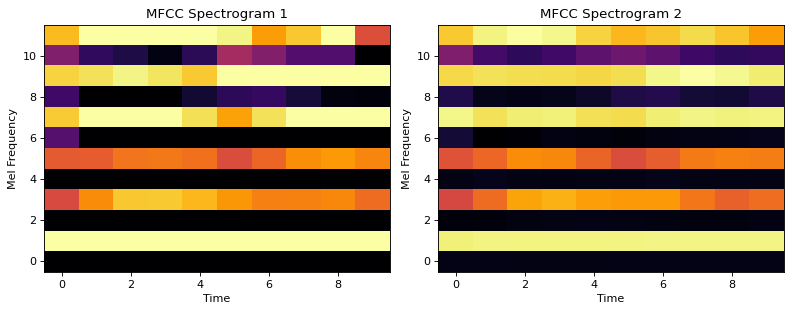

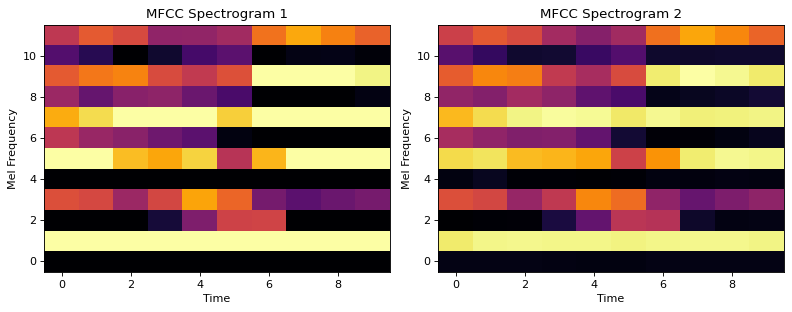

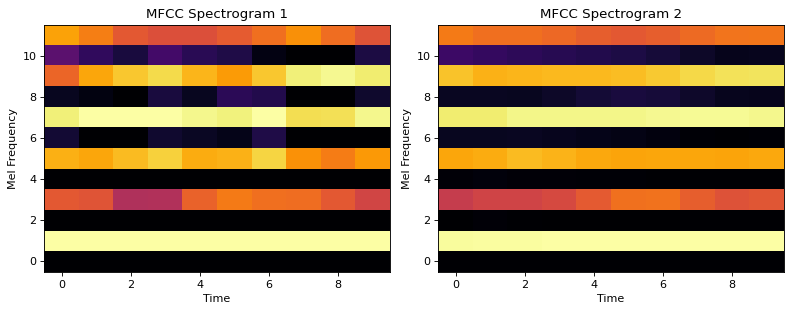

In [13]:
def plot_mfcc_spectrogram(mfccs, recon):
  plt.imshow(mfccs.T, cmap='inferno', aspect='auto', origin='lower')  # Plot using colormap
  plt.colorbar() # format='%2.f dB')  # Add colorbar
  plt.xlabel('Time')
  plt.ylabel('Mel Frequency')
  plt.title('MFCC Spectrogram')
  plt.tight_layout()
  plt.show()

def plot_mfcc_spectrograms_side_by_side(mfccs1, mfccs2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Create a figure with 2 subplots

    for i, (mfccs, ax) in enumerate(zip([mfccs1, mfccs2], axes)):
        ax.imshow(mfccs.T, cmap='inferno', aspect='auto', origin='lower')
        ax.set_title(f'MFCC Spectrogram {i + 1}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Mel Frequency')

    # fig.colorbar(axes[0].images[0], ax=axes, format='%2.f dB')  # Add single colorbar for both plots
    plt.tight_layout()
    plt.show()

plt.rcParams['figure.dpi'] = 80

for _ in range(3):
  index = random.randint(0, 500)
  example = dataset[index]
  reconstructed = vae.forward(dataset[index]).detach().cpu().numpy()
  plot_mfcc_spectrograms_side_by_side(example, reconstructed)

# plt.hist(dataset[index], bins=10)

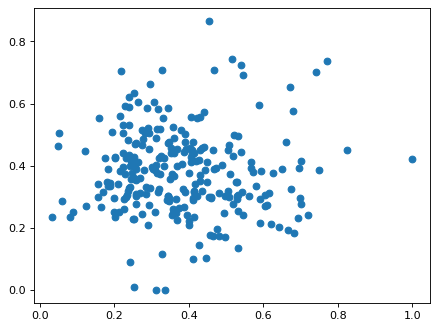

In [36]:
coords_16 = []
for index, filename in enumerate(dataset.mfcc_files):
  data = dataset[index]
  z, mu, log_var = vae.encoder.forward(data)
  latent_coordinate = mu.detach().cpu().numpy()
  coords_16.append(latent_coordinate)

coords_16 = np.array(coords_16).reshape((256, 16))

from sklearn.decomposition import PCA


# Create a PCA object specifying the number of components to retain (2)
pca = PCA(n_components=2)

# Fit the PCA model to the data (this computes the principal components)
pca.fit(coords_16)

# Transform the data using the fitted PCA model (projects data onto principal components)
coords_2 = pca.transform(coords_16)

min = np.min(coords_2)
max = np.max(coords_2)
epsilon = 0
coords_2 = (coords_2 - min) / (max - min + epsilon)


plt.scatter(coords_2[:, 0], coords_2[:, 1])



In [43]:
import json

latent_dict = {"cols": 2, "data": {}}
params_dict = {"cols": 8, "data": {}}

for index, filename in enumerate(dataset.mfcc_files):
  data = dataset[index]
  """z, mu, log_var = vae.encoder.forward(data)
  latent_coordinate = mu.detach().cpu().numpy()"""
  latent_coordinate = coords_2[index, :].astype(float).tolist()
  latent_dict["data"][f"point-{index}"] = latent_coordinate

  setting_string = filename.removeprefix("/content/MyDrive/MyDrive/KTH/aMASTER THESIS/Data/MFCC_12_split/")
  setting_string = setting_string.removesuffix("_1.npy")

  setting_list = setting_string.split("_")

  for i, setting in enumerate(setting_list):
    setting_list[i] = float("0." + setting.removeprefix("0"))

  params_dict["data"][f"point-{index}"] = setting_list



"""
# Convert the dictionary to JSON format
json_data_xy = json.dumps(data_dict, indent=4)  # indent for readability

# Write the JSON data to a file
with open("coordinates_xy.json", "w") as outfile:
    outfile.write(json_data_xy)

# Convert the dictionary to JSON format
json_data_params = json.dumps(params_dict, indent=4)  # indent for readability

# Write the JSON data to a file
with open("params.json", "w") as outfile:
    outfile.write(json_data_params)
"""


'\n# Convert the dictionary to JSON format\njson_data_xy = json.dumps(data_dict, indent=4)  # indent for readability\n\n# Write the JSON data to a file\nwith open("coordinates_xy.json", "w") as outfile:\n    outfile.write(json_data_xy)\n\n# Convert the dictionary to JSON format\njson_data_params = json.dumps(params_dict, indent=4)  # indent for readability\n\n# Write the JSON data to a file\nwith open("params.json", "w") as outfile:\n    outfile.write(json_data_params)\n'

In [44]:
# Convert the dictionary to JSON format
json_data_xy = json.dumps(latent_dict, indent=4)  # indent for readability

# Write the JSON data to a file
with open("/content/MyDrive/MyDrive/KTH/aMASTER THESIS/Data/json/xy.json", "w") as outfile:
    outfile.write(json_data_xy)

# Convert the dictionary to JSON format
json_data_params = json.dumps(params_dict, indent=4)  # indent for readability

# Write the JSON data to a file
with open("/content/MyDrive/MyDrive/KTH/aMASTER THESIS/Data/json/params.json", "w") as outfile:
    outfile.write(json_data_params)